In [1]:
import os
import sys
from pathlib import Path
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from scipy import ndimage
import skimage

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import cv2
import functions
from tutorials.unet_model import construct_unet

In [2]:
def load_dataset(root):
    transformers = functions.Compose([functions.FixResize(256), functions.ToTensor(), functions.Normalize()])

    val_dataset = functions.SolarDataset(root, image_folder="img/val", 
            mask_folder="ann/val", transforms=transformers)
    
    return val_dataset

In [3]:
def load_device_and_model(weight_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    unet = construct_unet(5)
    unet = torch.nn.DataParallel(unet)
    
    checkpoint = torch.load(weight_path, map_location=torch.device('cpu'))
    from collections import OrderedDict

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = "module." + k
        new_state_dict[name] = v

    unet.load_state_dict(new_state_dict)

    model = unet.module.to(device)
    
    return device, model

In [4]:
def show(mask, raw_img, test_res, layers_to_render=None, retrained=False):
    mask_cpu = mask.cpu().numpy()

    cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]

    fig, ax = plt.subplots(ncols=3, figsize=(12,12))

    im = ax[0].imshow(raw_img.convert('L'), cmap='gray', interpolation='None')
    ax[0].axis('off')

    clim = (0, 4)
    im = ax[1].imshow(mask_cpu, cmap='viridis', clim=clim)
    ax[1].axis('off')
    ax[1].set_title("Ground Truth Mask")

    if layers_to_render is not None:
        test_res = np.where(np.isin(test_res, layers_to_render), test_res, 0)

    ax[2].imshow(test_res, cmap='viridis', clim=clim, interpolation='None')
    handles, labels = ax[2].get_legend_handles_labels()

    for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in category_mapping.items()]):
            patch = mpatches.Patch(color=c, label=classlabel, ec='k')
            handles.append(patch)
    ax[2].legend(handles=handles, fontsize='x-small')
    ax[2].axis('off')
    if retrained:
        ax[2].set_title("Retrained Model Prediction")
    else:
        ax[2].set_title("Model Prediction")

def inference_and_show(idx, root, weight_path, batch_size=1, retrained=False, layers_to_render=None):
    val_dataset = load_dataset(root)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    device, model = load_device_and_model(weight_path)
    
    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)
    raw_img, _ = val_loader.dataset.__getraw__(idx)
    test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res = np.argmax(test_res, axis=0)
    
    show(mask, raw_img, test_res, retrained=retrained, layers_to_render=layers_to_render)


## Inference w/ Magic Values

### My model w/ my data

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_75827/484424128.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_locat

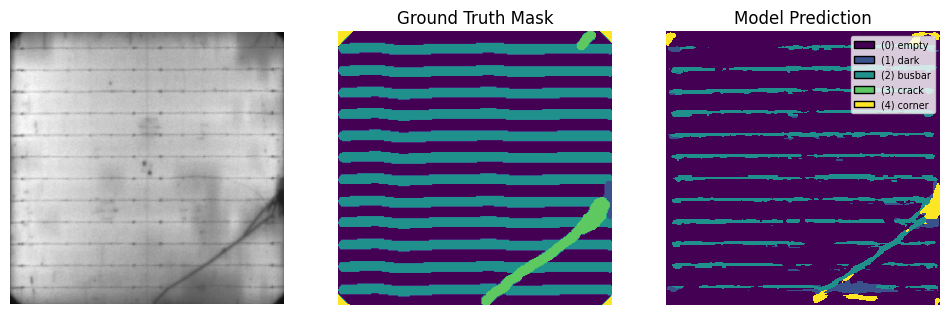

In [29]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}

# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
# weight_path = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt'
root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/")
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt"

inference_and_show(30, root, weight_path)

### Emma model with my data

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_75827/484424128.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_locat

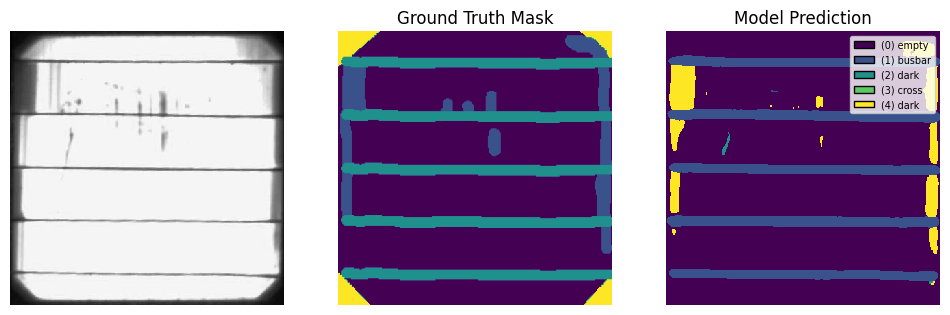

In [35]:
category_mapping = {0: "empty", 1: "busbar", 2: "dark", 3: "cross", 4: "dark"}

# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
# weight_path = '/home/osanghi/pvcracks/retrained_pv-vision_model.pt'
root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/")
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt"

inference_and_show(18, root, weight_path)

### My model with no corners data

In [ ]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}

root = Path('/projects/wg-psel-ml/EL_images/osanghi/Norman_ELImages_NoCorners/')
weight_path = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt'

inference_and_show(1, root, weight_path)

### Emma model w/ emma data

In [ ]:
category_mapping = {0: "empty", 1: "busbar", 2: "dark", 3: "cross", 4: "dark"}

root = Path('/projects/wg-psel-ml/EL_images/eccoope')
weight_path = '/home/osanghi/pvcracks/retrained_pv-vision_model.pt'

inference_and_show(1, root, weight_path)

### OG weights

In [ ]:
# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE')
# weight_path = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt'

In [ ]:
# inference_and_show(1, root, weight_path)